## Image registration

https://en.wikipedia.org/wiki/Image_registration

1. Intensity-based vs feature based
    1. Intensity-based: compare intensity patterns in images via correlation metrics
    2. feature-based: find correspondence between image features such as points, lines, and contours
2. **Transformation models**
    1. Linear -- Affine transform
    2. Elastic or nonrigid -- locally wrapping methods
    3. Diffeomorphic mapping -- LDDMM (Large deformation diffeomorphic metric mapping, https://en.wikipedia.org/wiki/Large_deformation_diffeomorphic_metric_mapping)
3. Spatial and frequency domain methods (phase correlation)
4. Single- vs multi-modality (imaging from different sources)

### Optimization -- Similarity measures for image registration

1. Mean square difference (intensity difference)
2. Mutual information (or nomalized mutual information) -- most popular one
3. Cross-correlation -- more computationally intensive than MI, can be useful for fine-scale nonlinear registration step
4. Ratio image uniformity (this could be useful while images from different imaging modality)
5. Landmark guidance

## Intra-modal registration

### Linear transform
Y = T X + b
### Rigid body transform
Rotation and translation.
### Affine transform (Unnecessary)
Rotation, translation, scaling and shears.


Ants code
```bash
antsRegistration --dimensionality 3 --float 0 \  
        --output [$thisfolder/pennTemplate_to_${sub}_,$thisfolder/pennTemplate_to_${sub}_Warped.nii.gz] \  
        --interpolation Linear \  
        --winsorize-image-intensities [0.005,0.995] \  # remove hot spots -- preprocessing
        --use-histogram-matching 0 \  # ajust the images with the same constrast -- preprocessing
        --initial-moving-transform [$t1brain,$template,1] \   
        --transform Affine[0.1] \  # 0.1 gradient descent step -- this is done using L-BFGS-B in dipy
        --metric MI[$t1brain,$template,1,32,Regular,0.25] \  # parameters are [fixed, moving, weight, bins, sampling, samplingPercentage]
        --convergence [1000x500x250x100,1e-6,10] \  # run 4 levels (or multi-resolution steps) with a maximum number of iterations of 1000,500,250,100. The threshold (1e-6) tells the algorithm to stop if the improvement in mutual information has not changed more than 1e-6 in the last 10 iterations  -- this is done using L-BFGS-B in dipy
        --shrink-factors 8x4x2x1 \  # the 4 hierarchical steps will have resolutions divided by 8,4,2,1
        --smoothing-sigmas 3x2x1x0vox #  smoothing values for each step: sigma 3,2,1,0
```

In [1]:
from skimage import transform as tf

In [2]:
# load data
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import h5py
h5f = h5py.File('../pixelwiseDenoising/testing_file/TM0000000_CM0_CHN00.h5', 'r')
imgStack = h5f['default'][:] # z, x, y
h5f.close()
# plt.imshow(imgStack[0], cmap='gray')
# fix = imgStack[0]
# np.save('fix', fix)
# fix = np.load('fix.npy')
# plt.imshow(fix, cmap='gray')
# plt.axis('off')
# plt.show()
fix = imgStack

/Users/dalin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import os, sys
fish_path = os.path.abspath(os.path.join('..'))
if fish_path not in sys.path:
    sys.path.append(fish_path)

In [4]:
from pixelwiseDenoising.simpleDenioseTool import simpleDNStack
fix = simpleDNStack(fix, '../pixelwiseDenoising/gainMat20180208')

In [5]:
tform = tf.AffineTransform(translation=(50, 50), rotation=-np.pi/30)
move = np.zeros(fix.shape)
for nPlane in range(len(fix)):
    move[nPlane] = tf.warp(fix[nPlane], tform, preserve_range=True)

In [6]:
fix.max()

221

In [7]:
from imPreprocessing import downscale
fix_ = downscale(fix, (1, 2, 2))
move_ = downscale(move, (1, 2, 2))

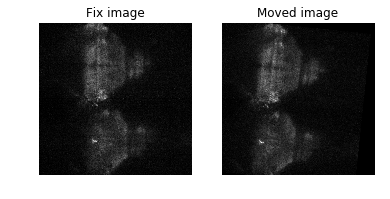

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(fix_[0], cmap='gray')
ax1.set_title('Fix image')
ax1.axis('off')
ax2.imshow(move_[0], cmap='gray')
ax2.set_title('Moved image')
ax2.axis('off')
plt.show()

### parameter ss_sigma_factor (Scale space sigma-factor ratio)

The scale space is a list of images produced by smoothing the input image with a Gaussian kernel with increasing smoothing parameter. If the image’s voxels are isotropic, the smoothing will be the same along all directions: at level L = 0, 1, ...; the sigma is given by s∗$(2^{L−1})$. If the voxel dimensions are not isotropic, then the smoothing is weaker along low resolution directions. This is good for z stack is much less than x, y dimensions. By default, **factor** and **sigma** are given as list with same length, or using **ss_sigma_factor=0.2** instead with given level (decided by parameter **level_iters**)

By default
```python
level_iters = [1000, 500, 250, 125]
factors = [8, 4, 2, 1]
sigmas = [3.0, 2.0, 1.0, 0.0]
ss_sigma_factor=None
```

### Translation
The following performance is at level_iters = $[10000, 1000, 100]$
```python
tform = tf.AffineTransform(translation=(50, 50), rotation=0)
```
> CPU times: user 2.69 s, sys: 384 ms, total: 3.08 s, Wall time: 2.93 s

### Rigid
```python
tform = tf.AffineTransform(translation=(50, 50), rotation=-np.pi/30)
trans_key ='rigid'
```
> CPU times: CPU times: user 30.9 s, sys: 1.39 s, total: 32.3 s, Wall time: 30.4 s
```python
tform = tf.AffineTransform(translation=(50, 50), rotation=-np.pi/30)
trans_key ='affine'
```
> CPU times: user 1min 5s, sys: 2.17 s, total: 1min 7s, Wall time: 1min 4s

### Performance is measued using comparison of the optimized transform to the known inverse transform
see test code below
1. affine is not necessary for this task.

### 3d Rigid

1. Performance using **affine**
> CPU times: user 31min 16s, sys: 3min 54s, total: 35min 10s, Wall time: 34min 30s
It also creates wired 3d rescaling and 3d rotation

2. Performance using **rigid**
>CPU times: user 14min 18s, sys: 2min 16s, total: 16min 35s, Wall time: 16min 10s

3. Performance using **translation**, ss_sigma_factor = 1
> CPU times: user 6min 2s, sys: 1min, total: 7min 2s, Wall time: 6min 53s

4. Performance using **translation**, sigma and factor is given as default
> CPU times: user 5min 56s, sys: 59.5 s, total: 6min 56s, Wall time: 6min 48s

In [9]:
from imTrans import ImAffine

In [10]:
# %%time
transAffine = ImAffine()
transAffine.ss_sigma_factor = 1.0
transAffine.level_iters = [1000, 1000, 100]
transAffine.verbosity = 1
# out_affine = transAffine.estimate_rigidxy(fix, move)

In [11]:
# out__ = transAffine.estimate_rigid_projz(fix, move)

In [12]:
# warped_ = out__.transform(move)
# f, (ax1, ax2) = plt.subplots(1, 2)
# ax1.imshow(fix[20], cmap='gray')
# ax1.set_title('Fix image')
# ax1.axis('off')
# ax2.imshow(warped_[20], cmap='gray')
# ax2.set_title('Affined moved image')
# ax2.axis('off')
# plt.show()
# # # plt.imshow((fix-fix.mean())/fix.std() - (warped_-warped_.mean())/warped_.std())
# # # plt.colorbar()
# # # plt.show()

In [13]:
tform = tf.AffineTransform(translation=(50, 100))
move = np.zeros(fix.shape)
for nPlane in range(len(fix)):
    move[nPlane] = tf.warp(fix[nPlane], tform, preserve_range=True)

In [19]:
%%time
transAffine.ss_sigma_factor = None
transAffine.sigmas = [3., 1., 0.]
transAffine.factors = [4, 2, 1]
transAffine.verbosity = 0
transAffine.options['disp'] = False
out_affine = transAffine.estimate_translation3d(fix, move)

CPU times: user 20min 30s, sys: 2min 36s, total: 23min 7s
Wall time: 30min 41s


In [15]:
out_affine.affine

NameError: name 'out_affine' is not defined

In [ ]:
# # test of the results with know reverse of rotations
# rotationMat = tf.warp(np.ones(fix[0].shape), tform)
# inv_tform = tf.AffineTransform(translation=(-50, -50), rotation=np.pi/30)
# raw = tf.warp(rotationMat, inv_tform)
# rotationStack = np.tile(rotationMat, (len(fix), 1, 1))
# transformMat = out_affine.transform(rotationStack)
# # np.abs(invRot-transformRot).mean()

In [ ]:
# from tifffile import imsave
# imsave('fix.tif', fix.astype('uint8'))
# imsave('move.tif', move.astype('uint8'))

In [ ]:
# plt.imshow(raw-transformMat[20])
# # diff_mat = (fix-fix.mean())/fix.std() - (warped_-warped_.mean())/warped_.std()
# # np.abs(diff_mat).mean()

## Inter-modal registration

### Nonliear transform -- Large deformation diffeomorphic metric mapping (LDDMM)

Image I is a diffeomorphism of template image $I_{tmp}$ as $\psi: I_{tmp} \rightarrow I$ and $\psi \in Diff_v$, and $I = I_{tmp} \circ \psi$ ($\circ$ elementwise multiplication).

The diffeomorphisms are generated via smooth flows $\phi_t$ ($t\in[0,1]$), $\psi = \phi_1$ satisfying the  Lagrangian and Eulerian specification of the flow field associated to the ordinary differential equation, $\frac{d}{dt}\phi_t = v_t \circ \phi_t$ and $\phi_0 = id$

![](ant-syn.png)

1. First term (in blue): smoothness term (or diffeomorphic regularization) -- Minimize a smooth velocity field: the geodesic path between two images. L is a smoothing operator, v is a transform (velocity field), t is time.
2. Second term (rest): similarity metrics

## live registration
```bash
antsRegistration -d 3 –float 1 -o [fish1 , fish1 Warped.nii.gz] \
                 --interpolation WelchWindowedSinc \
                 --use-histogram-matching 0 \
                 -r [ref/vglut-ref.nii, fish1–01.nii.gz,1] \
                 -t rigid[0.1]\
                 -m MI[ref/vglut-ref.nii, fish1–01.nii.gz,1,32, Regular,0.25]\
                 -c [200x200x200x0,1e-8,10]\ 
                 --shrink-factors 12x8x4x2\
                 --smoothing-sigmas 4x3x2x1vox\
                 -t Affine[0.1]
                 -m MI[ref/vglut-ref.nii, fish1–01.nii.gz,1,32, Regular,0.25]
                 -c [200x200x200x0,1e-8,10]
                 --shrink-factors 12x8x4x2
                 --smoothing-sigmas 4x3x2x1vox
                 -t SyN[0.05,6,0.5]
                 -m CC[ref/vglut-ref.nii, fish1–01.nii.gz,1,2]
                 -c [200x200x200x200x10,1e-7,10]
                 --shrink-factors 12x8x4x2x1
                 --smoothing-sigmas 4x3x2x1x0vox

```

float : 0 (double), 1 (float)
interpolation: Several interpolation options are available in ITK. These have all been made available. Currently the interpolator choice is only used to warp (and possibly inverse warp) the final output image(s).

## fixed registration
for Syn using parameters[0.1,6,0]
